# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
df=pd.read_csv(r"languages.csv",encoding="utf_8")

# Data Exploration and Pre Processing

In [2]:
df.head(10)

,sentence,language
0,Отпустите меня!,Russian
1,今日は、少しかみがたをかえようかなと思ってるんです。,Japanese
2,"Quando decideva di fare qualcosa, lo faceva.",Italian
3,বিমানত উৰি থাকোঁতে পিয়ানো বজাই আছে।,Assamese
4,Mettersi a piangere/ridere...,Italian
5,Otthonról dolgozom.,Hungarian
6,Costă zece lei,Romanian
7,Ich habe beim Dartturnier mit einem Langbogen ...,German
8,Está na sua mala.,Portugese
9,ik heb niets te verliezen.,Dutch


In [3]:
#df= df[df['language'] != "Japanese"]
#df= df[df['language'] != "Russian"]
#df= df[df['language'] != "Mandarin"]
#df= df[df['language'] != "Arabic"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10407 non-null  object
 1   language  10408 non-null  object
dtypes: object(2)
memory usage: 162.8+ KB


In [5]:
df['language'].value_counts()

Italian           1123
French            1059
Arabic             817
Russian            782
German             697
Japanese           671
Haitian Creole     569
Dutch              559
Punjabi            545
Romanian           539
Assamese           534
Bengali            507
Vietnamese         307
Korean             299
Spanish            290
English            286
Portugese          256
Greek              243
Mandarin           169
Hungarian          156
Name: language, dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

sentence    0
language    0
dtype: int64

In [7]:
df.sentence = df.sentence.str.replace('\d+', '')
x =np.array(df['sentence'])
y= np.array(df['language'])

<ipython-input-7-059b80e2516a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.sentence = df.sentence.str.replace('\d+', '')


In [8]:
c = CountVectorizer()
xmatrix = c.fit_transform(x)
xarray = xmatrix.toarray()
df = pd.DataFrame(data=xarray,columns = c.get_feature_names())
print(df)

       aan  aandoen  aangekomen  aangifte  aankomen  aanmaken  aanstaande  \
0        0        0           0         0         0         0           0   
1        0        0           0         0         0         0           0   
2        0        0           0         0         0         0           0   
3        0        0           0         0         0         0           0   
4        0        0           0         0         0         0           0   
...    ...      ...         ...       ...       ...       ...         ...   
10402    0        0           0         0         0         0           0   
10403    0        0           0         0         0         0           0   
10404    0        0           0         0         0         0           0   
10405    0        0           0         0         0         0           0   
10406    0        0           0         0         0         0           0   

       aanwezig  aardbeien  ab  ...  함께  해야  해요  핸드폰  했어요  혼자  홍대하고  화장  후에

In [9]:
xtrain,xtest,ytrain,ytest = train_test_split(xmatrix,y,test_size = 0.20)

# Model Building

In [10]:
accuracies=[]

# Multinomial Naive Bayes Classifier

In [11]:
nb = MultinomialNB()
nb.fit(xtrain,ytrain)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
predlanguage=nb.predict(data)[0]
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["Multinomial Naive Bayes",nb.score(xtrain,ytrain)*100,nb.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Italian
Actual Language: Italian


# Linear Support Vector Classifier

In [12]:
svc = LinearSVC()
svc.fit(xtrain,ytrain)
ypred=svc.predict(xtest)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
predlanguage=svc.predict(data)[0]
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["Linear Support Vector Classifier",svc.score(xtrain,ytrain)*100,svc.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Italian
Actual Language: Italian


# Logistic Regression

In [13]:
lr = LogisticRegression(random_state=1)
lr.fit(xtrain,ytrain)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
predlanguage=lr.predict(data)[0]
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["Logistic Regression",lr.score(xtrain,ytrain)*100,lr.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Italian
Actual Language: Italian


# Random Forest Classifier

error=[]
for i in range (60,80):
    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(xtrain, ytrain)
    pred_i=rf.predict(xtest)
    error.append(np.mean(pred_i!=ytest))
plt.figure(figsize=(12,6))
plt.plot(range(60,80),error,color='black',linestyle='dashed',marker='o',markerfacecolor='red')
plt.title('Error rate vs random state values')
plt.xlabel('random state')
plt.ylabel('error')

In [14]:
rf=RandomForestClassifier(n_estimators=100, random_state=67)
rf.fit(xtrain,ytrain)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
predlanguage=rf.predict(data)[0]
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["Random Forest",rf.score(xtrain,ytrain)*100,rf.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Italian
Actual Language: Italian


# K-Nearest Neighbours Classifier

error=[]
for i in range (0,10):
    knn= KNeighborsClassifier(n_neighbors=i)
    knn.fit(xtrain, ytrain)
    pred_i=knn.predict(xtest)
    error.append(np.mean(pred_i!=ytest))
plt.figure(figsize=(12,6))
plt.plot(range(0,10),error,color='black',linestyle='dashed',marker='o',markerfacecolor='red')
plt.title('Error rate vs k values')
plt.xlabel('k values')
plt.ylabel('error')

In [15]:
knn= KNeighborsClassifier(n_neighbors=10)
knn.fit(xtrain,ytrain)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
predlanguage=knn.predict(data)[0]
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["K-Nearest Neighbours",knn.score(xtrain,ytrain)*100,knn.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Bengali
Actual Language: Italian


# Decision Tree Classifier

In [16]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(xtrain, ytrain)
text = ('Sono uno studente del college')
data = c.transform([text]).toarray()
print("Input Sentence:",end=" ")
print(text)
print("Predicted Language:", end=" ")
predlanguage=lr.predict(data)[0]
print(predlanguage)
print("Actual Language: Italian")
accuracies.append(["Decision Tree",dt.score(xtrain,ytrain)*100,dt.score(xtest,ytest)*100])

Input Sentence: Sono uno studente del college
Predicted Language: Italian
Actual Language: Italian


# Evaluating the Models

In [17]:
sorted_accuracies = sorted(accuracies, key=lambda x: x[2])
print (tabulate(sorted_accuracies, headers=["Model Name", "Training Accuracy", "Testing Accuracy"]))

Model Name                          Training Accuracy    Testing Accuracy
--------------------------------  -------------------  ------------------
K-Nearest Neighbours                          58.2583             44.3324
Decision Tree                                 99.9279             76.7051
Random Forest                                 99.9279             84.2459
Logistic Regression                           96.9129             86.5514
Multinomial Naive Bayes                       96.5285             88.1844
Linear Support Vector Classifier              99.9039             90.4419


In [18]:
text = ('Mi piacciono anche i cani, ma mi piacciono di più i gatti.') #italian
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Italian


In [19]:
text = ('أنا أحب الكلاب أيضًا ، لكني أحب القطط أكثر.') #arabic
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Arabic


In [20]:
text = ('Főiskolai hallgató vagyok') #hungarian
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Hungarian


In [21]:
text = ('es ist heute zu heiß, wir sollten Eis essen') #german
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

German


In [22]:
text = ('También me gustan los perros, pero me gustan más los gatos.') #spanish
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Spanish


In [23]:
text = ('κάνει πολύ ζέστη σήμερα, πρέπει να φάμε παγωτό') #greek
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Greek


In [24]:
text = ('ਕੀ ਇਹ ਤੁਹਾਡੇ ਨਾਲ ਗੱਲ ਕਰਨ ਦਾ ਚੰਗਾ ਸਮਾਂ ਹੈ') #punjabi
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Punjabi


In [25]:
text = ('आज बहुत गर्मी है, हमें आइसक्रीम खानी चाहिए') #hindi
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Japanese


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

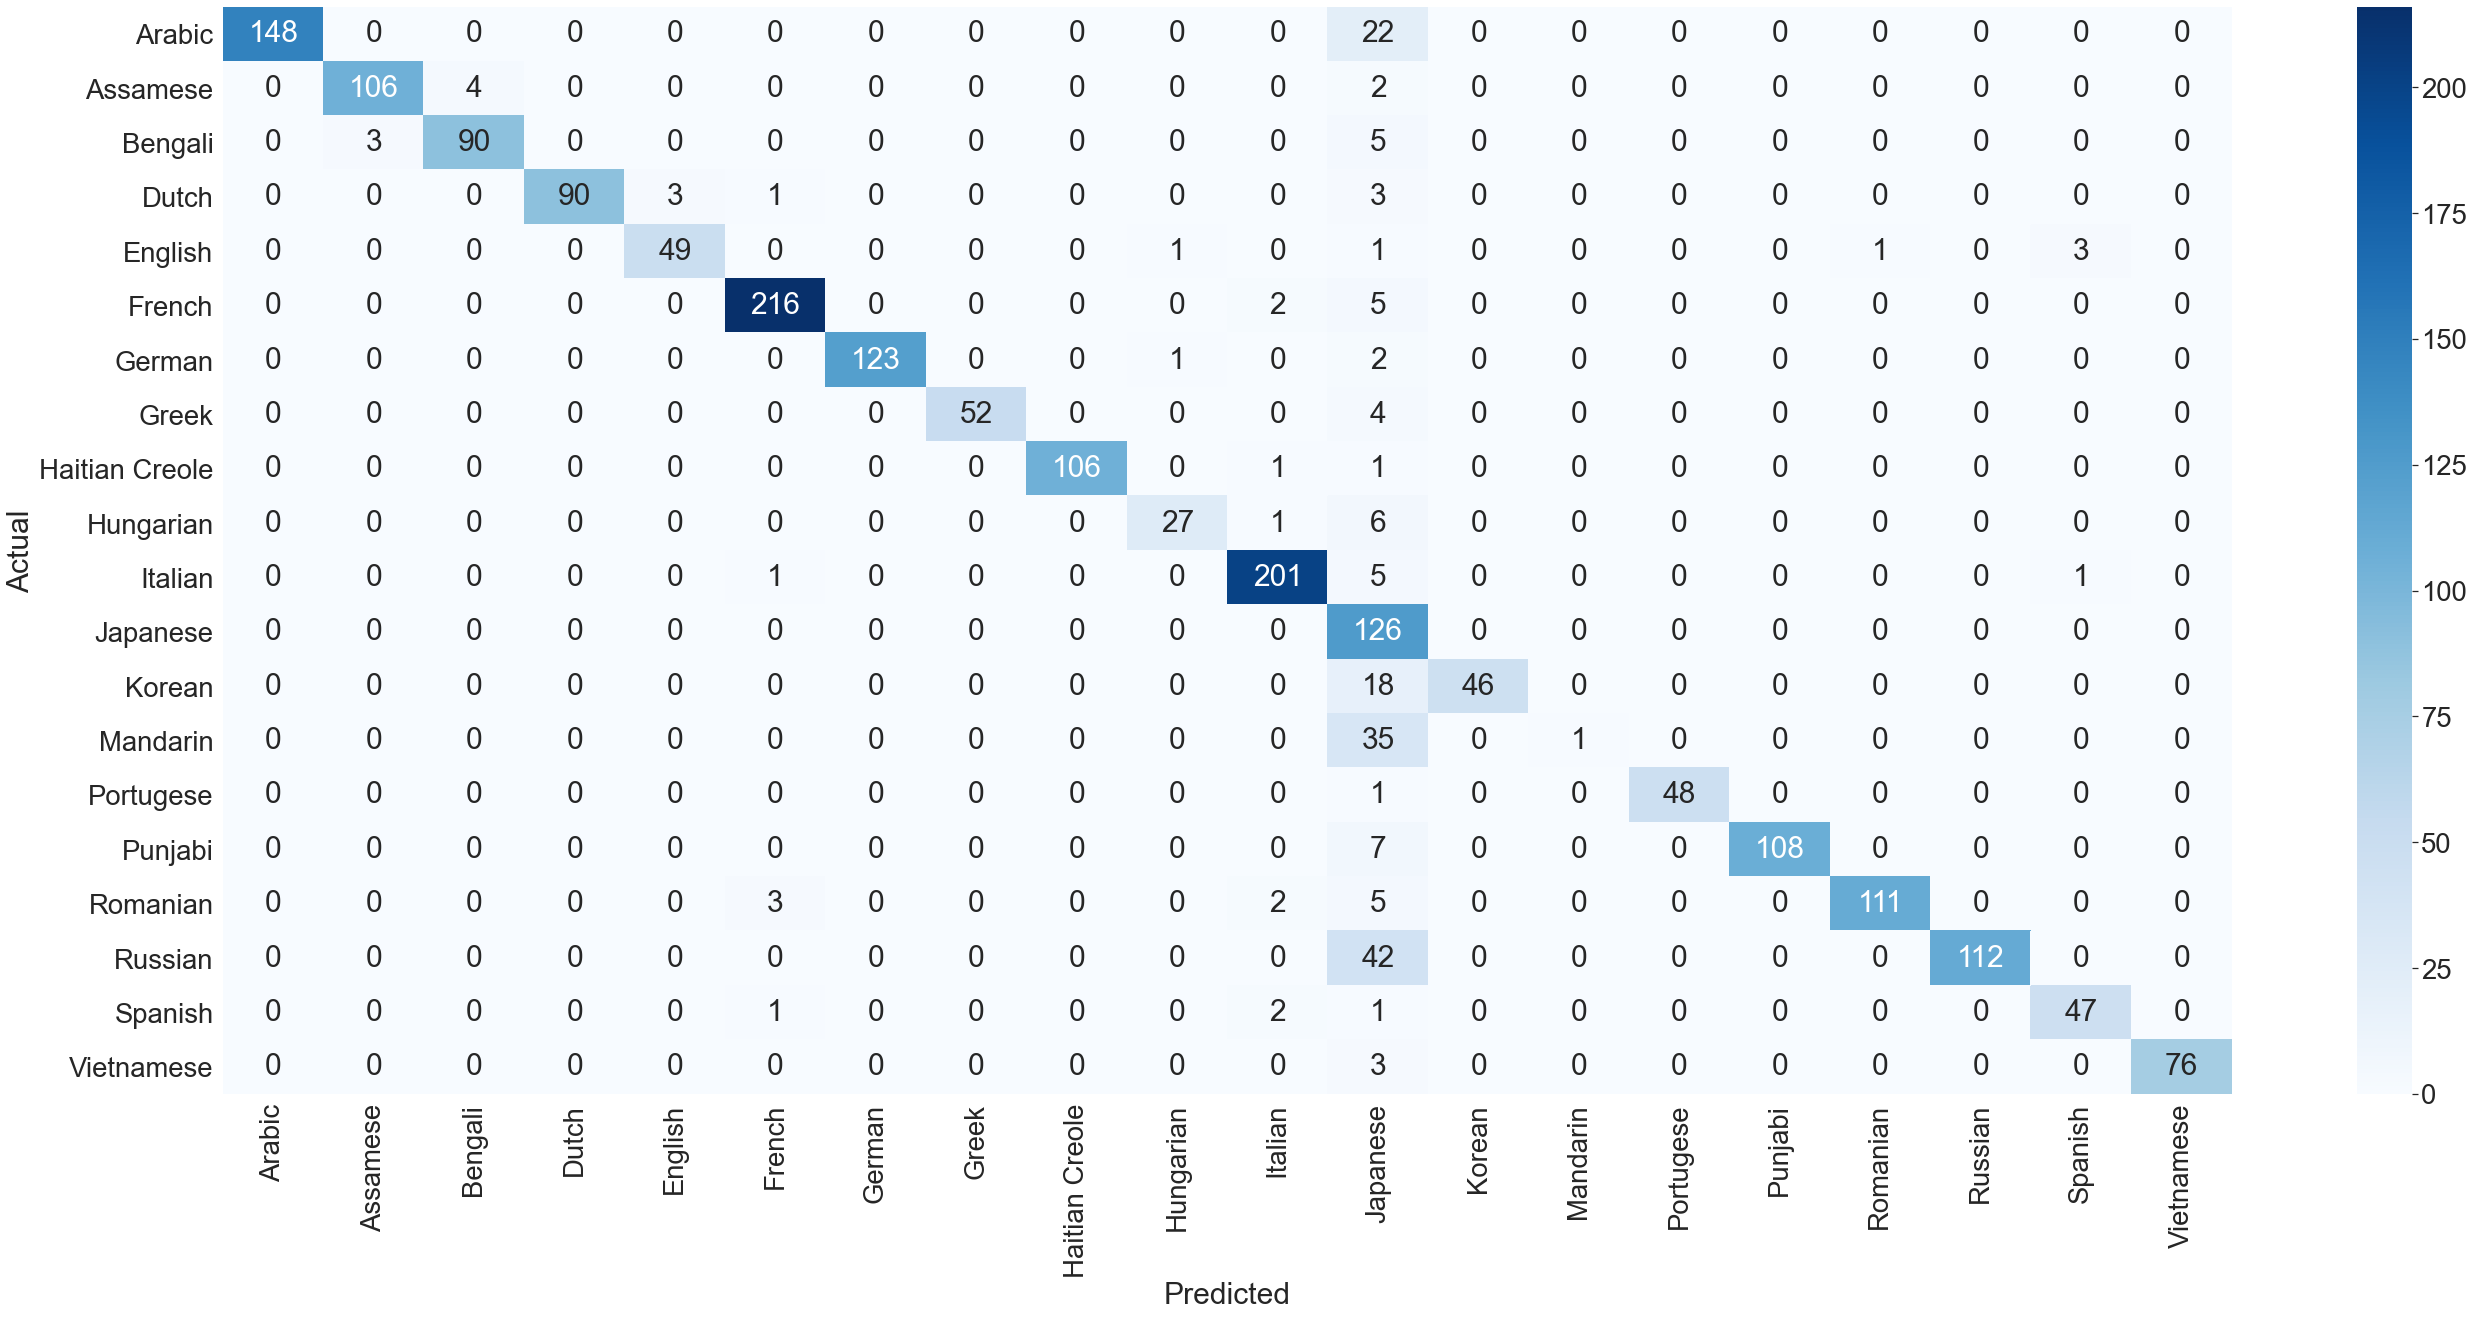

In [26]:
np.set_printoptions(linewidth=np.inf)
labels = np.unique(ytest)
data=confusion_matrix(ytest, ypred,labels=labels)
df_cm = pd.DataFrame(data, columns=np.unique(ytest), index = np.unique(ytest))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (45,20))
sns.set(font_scale=2.5)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 30}, fmt='g')

In [27]:
text = ('put text here') #tryit
data = c.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

English
